# Understand the problems
Disclaimer, the content below is for brainstorming only. I have a PDF report, please read that.
## Context
Having csv file containing information about car listings. Defined tasks:
1. Build a model
- Work on brands make up 90% of the total cars -> Filtering rare cars (from each brand) -> Filtering rare brands.
- Predict the price of used cars -> Regression task
2. Define a success metrics 
- Maybe metrics related to regression tasks, including: R-squared and MAE; for monotonic constraints, we can also use differentiable loss function: RMSE
3. Build an API
- Objective is to develop a RESTful API for the model mentioned above -> Since this is a demo, maybe i will stick with FastAPI for a fast demo.
4. Data Analysis Questions
- How does mileage relate to car price? Is there a clear negative correlation? -> I think this question is more data-centric instead of model-centric, therefore using modeling techniques like SHAP value to interprete maybe is not suitable. Thus, sticking with statistic methods maybe more general. 
- Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price? -> I can reframe this question as is fuel type is statistical significant with the price -> Maybe using statistics test -> Using some libraries. 
- How to compare two cars in the same segment? -> Still thinking (what is segment mean?)

## Scoring objective:
- How well does your model perform -> This maybe strongly related to the chosen metrics. 
- How effective is the selected metric in evaluating model performance -> Are these metrics align with what people are doing in real-life problem?
- How could your model be improved? -> Tbh, both modeling and data preparation are needed in order to improve the model's prediction. 

# Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys
from api.preprocess import drop_unncessary_columns, cast_to_category, encode_cat_cols, convert_data_dmatrix
from api.constants import CAT_COLS, NUM_COLS, COLS_TO_CAST, COLS_TO_CAST, SAMPLE_DATA

In [2]:
# Load data
DATA_PATH = 'data'
MODEL_PATH = 'models'

In [55]:
ref = pd.read_csv(f'{DATA_PATH}/raw/car.csv') # for reference if needed
data = pd.read_csv(f'{DATA_PATH}/raw/car.csv')
unique_df = ref[~ref.duplicated()]
unique_df

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317611,150748445,110565749,1696580444000,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,150811050,110619804,1696753826000,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,150840647,110645035,1696835873000,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used
317618,148874300,108958993,1696836032000,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used


# EDA and Preprocessing

## Overview

In [56]:
# Check for the shape of the data
data.shape

(317636, 15)

Currently, the data has 317636 rows  with 15 columns

In [57]:
# Check for the first 5 rows of the data
data.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used


This is what the first 5 records look like. It seems that id, list_id, list_time are quite vague -> need to ask stakeholders about the data dictionary.

In [58]:
# We care for some statistics of the data
data.describe()

,id,list_id,list_time,manufacture_date,seats,mileage_v2,price
count,3.176360e+05,3.176360e+05,3.176360e+05,317636.00000,283792.000000,317636.000000,3.175240e+05
mean,1.489581e+08,1.090510e+08,1.695835e+12,2016.53675,5.712529,61327.917528,6.265541e+08
std,3.484644e+06,2.878699e+06,1.131473e+09,26.07318,1.780515,92679.788593,7.284020e+08
min,4.588559e+07,2.989052e+07,1.691400e+12,-1.00000,-1.000000,0.000000,1.310720e+06
25%,1.490832e+08,1.091366e+08,1.695113e+12,2014.00000,5.000000,9000.000000,3.150000e+08
50%,1.499784e+08,1.099032e+08,1.695873e+12,2019.00000,5.000000,42000.000000,4.900000e+08
75%,1.504550e+08,1.103140e+08,1.696577e+12,2022.00000,7.000000,82000.000000,7.150000e+08
max,1.513698e+08,1.110970e+08,1.698210e+12,2023.00000,16.000000,999999.000000,3.750000e+10


We can see that manufacture_date and seats has negative values in it, which impose errors. We should drop those records as well.

In [59]:
data.describe(include='object')

,brand,model,origin,type,gearbox,fuel,color,condition
count,317586,317586,234317,272934,316243,317542,221540,317636
unique,67,521,10,9,4,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,65455,15719,116368,90709,239222,259244,72035,270089


We can see that there are 67 brands and 521 models in total, however there may be some duplicate as well. Which make statistics unreliable.

In [60]:
# Drop the id, list_id, list_time columns
data = data.drop(['id', 'list_id', 'list_time'], axis=1)

In [61]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317631,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used
317632,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317633,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317634,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used


Ok, so after we drop useless columns, we can further investigate the records. As observe within the dataframe, there are some NaN values, which may impose error. Further investigation must resolve this problem.

## Convert data types

In [62]:
# Check for the data types of the columns
data.dtypes

manufacture_date      int64
brand                object
model                object
origin               object
type                 object
seats               float64
gearbox              object
fuel                 object
color                object
mileage_v2            int64
price               float64
condition            object
dtype: object

In [63]:
# Convert data types of the columns
data['brand'] = data['brand'].astype('category')
data['model'] = data['model'].astype('category')
data['origin'] = data['origin'].astype('category')    
data['gearbox'] = data['gearbox'].astype('category')
data['fuel'] = data['fuel'].astype('category')
data['type'] = data['type'].astype('category')
data['color'] = data['color'].astype('category')
data['condition'] = data['condition'].astype('category')
data.dtypes

manufacture_date       int64
brand               category
model               category
origin              category
type                category
seats                float64
gearbox             category
fuel                category
color               category
mileage_v2             int64
price                float64
condition           category
dtype: object

We have to convert the data back to the correct data type. Although in some scenario, object and category can be used interchangeably, I still prefer category over object, especially for these variable.

## Handling duplicate

In [64]:
# Display several duplicates
duplicates = data[data.duplicated(keep=False) | data.duplicated(keep='first')]
duplicates.sort_values(by=list(duplicates.columns))

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
44959,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58892,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58893,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
79332,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
...,...,...,...,...,...,...,...,...,...,...,...,...
19763,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41234,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41235,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
56436,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used


We can say that the data is duplicate a lot. Therefore I will decide to drop those duplicated columns. Additionally, some error data also occurs in the dataset as well. We will need to remove them too.

In [65]:
data = data.drop_duplicates()
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 42083 rows and 12 columns


In [66]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


The size of the data has been dramatically decrease. However, the sale price of the car can also be effected by the perspective of the seller. Therefore, some scenarios where different salers have different prices for the same car. We will comeback to this step later, after we dealing with missing values, and after that, we can define those records again.

## Handling missing values

In [67]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,4,0.009505,category
model,4,0.009505,category
origin,12174,28.928546,category
type,5932,14.095953,category
seats,4724,11.225435,float64
gearbox,190,0.451489,category
fuel,6,0.014258,category
color,13036,30.976879,category
mileage_v2,0,0.000000,int64


If we put ourselves under the view of the buyer, we will definately not buy the car if we do not know what brand it was or what model it was. Therefore these fields may be very important to determine the sale price of the car. With that being said, I will drop records where brand, model and price is empty. 

In [68]:
# Records with missing values in the 'price','brand','model' column
# Select and print records with missing values in 'brand', 'model', and 'price'
missing_records = data[data[['brand', 'model', 'price']].isnull().any(axis=1)]
print("Records with missing values in 'brand', 'model', and 'target':")
missing_records

Records with missing values in 'brand', 'model', and 'target':


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1059,2023,Hyundai,Grand i10,Việt Nam,NaN,5.0,AT,petrol,NaN,0,NaN,new
1727,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used
5517,2005,Ford,Transit,NaN,Van,16.0,MT,oil,NaN,280000,NaN,used
12848,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,NaN,0,NaN,new
20958,2022,Suzuki,Ertiga,Nước khác,NaN,7.0,AT,hybrid,NaN,0,NaN,new
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,890000000.0,used
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new


Maybe I will keep records with missing price for later inferencing (if these records are missing the price only). The remains can be dropped.

In [69]:
# Keep records with missing 'price' only
missing_price_only = data[data['price'].isnull() & data.drop(columns=['price']).notnull().all(axis=1)]
print("Records with missing 'price' only:")
missing_price_only

Records with missing 'price' only:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
169034,2023,Hyundai,Custin,Việt Nam,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181000,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181926,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,black,0,NaN,new


In [70]:
missing_price_only.to_csv((f'{DATA_PATH}/raw/inference.csv'), index=False)
data = data[~data.index.isin(missing_records.index)]


In [71]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,12166,28.923969,category
type,5924,14.083971,category
seats,4719,11.219153,float64
gearbox,190,0.451714,category
fuel,2,0.004755,category
color,13023,30.961438,category
mileage_v2,0,0.000000,int64


Ok, now we need to further investigate to see what we can do to the remaining missing values. 

In [72]:
# Overall statistics of the data
data.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,42062.000000,42062,42062,29896,36138,37343.000000,41872,42060,29039,42062.000000,4.206200e+04,42062
unique,NaN,67,521,10,9,NaN,4,4,12,NaN,NaN,2
top,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,8957,2067,14697,12489,NaN,30162,34847,9358,NaN,NaN,38343
mean,2016.082640,NaN,NaN,NaN,NaN,5.661945,NaN,NaN,NaN,70524.350601,5.677237e+08,NaN
std,6.370362,NaN,NaN,NaN,NaN,1.737503,NaN,NaN,NaN,103365.243520,7.137355e+08,NaN
min,1980.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN
25%,2013.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,14000.000000,2.750000e+08,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.500000e+08,NaN
75%,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,90000.000000,6.500000e+08,NaN


In [73]:
3.75e10

37500000000.0

There is a car around 37Bil VND (kinda suspicious). There is also a car that ran 999999 km (kinda suspicious for me) .Seats also have a values where it is equal to -1, which is obviously wrong :). Detect and drop those as well. 

In [74]:
# Drop rows where seats is less than or equal to 0
data = data[data['seats'] > 0]

data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [75]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,37222.000000,37222.000000,37222.000000,3.722200e+04
mean,2016.252593,5.683601,69975.821718,5.624639e+08
std,6.178039,1.698230,101096.358858,6.318453e+08
min,1980.000000,2.000000,0.000000,1.310720e+06
25%,2013.000000,5.000000,14278.250000,2.820000e+08
50%,2018.000000,5.000000,50000.000000,4.550000e+08
75%,2021.000000,7.000000,90000.000000,6.500000e+08
max,2023.000000,16.000000,999999.000000,3.750000e+10


In [76]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,37222,37222,28757,35511,37032,37222,28181,37222
unique,66,481,10,9,3,4,12,2
top,Toyota,Innova,Việt Nam,Sedan,AT,petrol,white,used
freq,8078,1914,14246,12332,26820,30766,9044,33557


In [77]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,8465,22.741927,category
type,1711,4.596744,category
seats,0,0.000000,float64
gearbox,190,0.510451,category
fuel,0,0.000000,category
color,9041,24.289399,category
mileage_v2,0,0.000000,int64


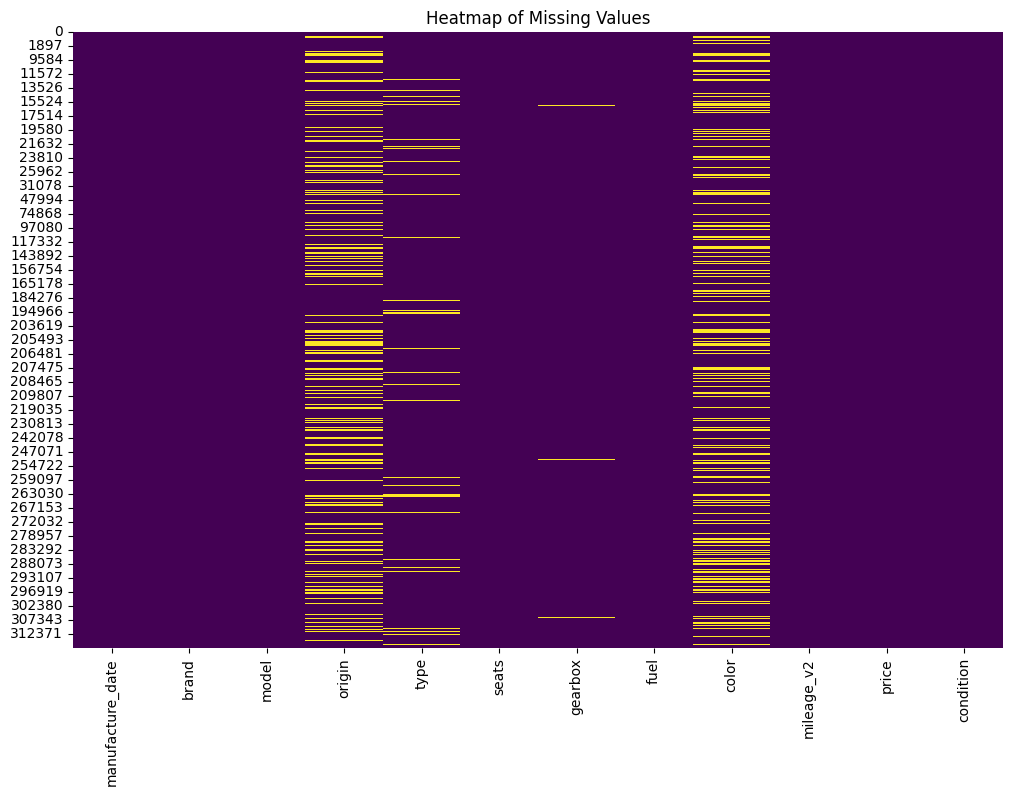

In [78]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

We can see that there is some missing regions, my best guests is that something must went wrong in the data gathering process, which lead to this bizard situations. I suspect that some brand and models are so unique such that it only have one type/origin or so on. I will need to investigate on that as well. 

In [79]:
# Group by 'brand' and 'model' and count occurrences
brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')
# Sort the values in descending order
brand_model_counts = brand_model_counts.sort_values(by='count', ascending=False)

/tmp/ipykernel_31947/3156361840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')


In [80]:
# Identify unique or rare combinations
unique_combinations = brand_model_counts[(brand_model_counts['count'] >= 1) & (brand_model_counts['count'] <= 5)]
# Filter the original DataFrame to get records with unique combinations
unique_records = data[data.set_index(['brand', 'model']).index.isin(unique_combinations.set_index(['brand', 'model']).index)]
print("Records with unique or rare brand and model combinations:")
unique_records

Records with unique or rare brand and model combinations:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
76,2023,Hyundai,County,Việt Nam,Minivan (MPV),7.0,AT,petrol,black,0,848000000.0,new
1264,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,200000000.0,used
1301,2005,Suzuki,Alto,NaN,NaN,2.0,MT,petrol,NaN,6789,58000000.0,used
1341,2003,Hyundai,Libero,Hàn Quốc,Pick-up (bán tải),4.0,MT,oil,white,262000,125000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
315307,1995,Jeep,CJ,Trung Quốc,NaN,5.0,MT,petrol,others,145874,80000000.0,used
316805,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used
317147,1980,Jeep,CJ,Mỹ,Mui trần,4.0,MT,petrol,red,10000,132000000.0,used
317166,1997,Lada,Dòng khác,Nhật Bản,Sedan,5.0,MT,hybrid,blue,1235,10000000.0,used


In [81]:
unique_records.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,530.000000,530,530,485,456,530.000000,530,530,453,530.000000,5.300000e+02,530
unique,NaN,61,219,10,9,NaN,3,4,12,NaN,NaN,2
top,NaN,Hyundai,Dòng khác,Nhật Bản,SUV / Cross over,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,43,75,80,143,NaN,335,440,103,NaN,NaN,508
mean,2008.352830,NaN,NaN,NaN,NaN,5.079245,NaN,NaN,NaN,95350.813208,9.983483e+08,NaN
std,10.312235,NaN,NaN,NaN,NaN,1.560786,NaN,NaN,NaN,151134.620010,2.303395e+09,NaN
min,1980.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,5.000000e+06,NaN
25%,2004.000000,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,14250.000000,1.050000e+08,NaN
50%,2009.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,60000.000000,2.900000e+08,NaN
75%,2016.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,104750.000000,6.500000e+08,NaN


In [82]:
# Check if there is any missing values in these records
unique_records_missing = unique_records.isnull().sum()
unique_records_missing 

manufacture_date     0
brand                0
model                0
origin              45
type                74
seats                0
gearbox              0
fuel                 0
color               77
mileage_v2           0
price                0
condition            0
dtype: int64

I don't see how this can be integrate with the current workflow. However, people should not selling cars which the origin of the cars is unknown, and because the origin is unknown, we can not sell the car legally (Based on this link: https://www.baogiaothong.vn/he-luy-khi-mua-xe-khong-giay-to-192240319074428423.htm). With that being said, car with unknown origin should be dropped since it may cause unpredictable effect when aligning between business logic and model logic.

In [83]:
data = data.dropna(subset=['origin'])
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 28757 rows and 12 columns


In [84]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [85]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1379,4.795354,category
seats,0,0.000000,float64
gearbox,119,0.413812,category
fuel,0,0.000000,category
color,3927,13.655806,category
mileage_v2,0,0.000000,int64


In [86]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,28757.000000,28757.000000,28757.000000,2.875700e+04
mean,2016.337518,5.672567,67985.473415,5.766872e+08
std,6.433763,1.703250,101642.499146,6.568278e+08
min,1980.000000,2.000000,0.000000,1.310720e+06
25%,2013.000000,5.000000,11000.000000,2.800000e+08
50%,2018.000000,5.000000,48000.000000,4.600000e+08
75%,2021.000000,7.000000,90000.000000,6.700000e+08
max,2023.000000,16.000000,999999.000000,3.750000e+10


In [87]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,28757,28757,28757,27378,28638,28757,24830,28757
unique,66,472,10,9,3,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,6074,1434,14246,9367,20911,23532,7896,25108


Now the remaining problems is how to deal with origin, type and color. When we reach this step, I think that visualization will be a very powerful tool. So let dive in !

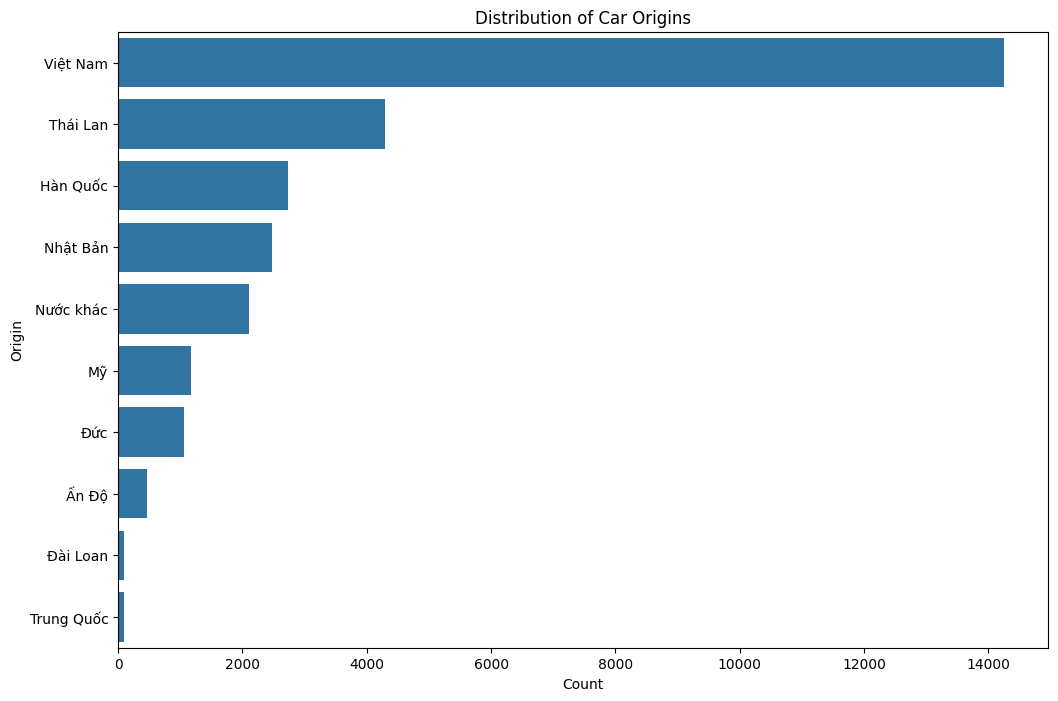

In [88]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='origin', order=data['origin'].value_counts().index)
plt.title('Distribution of Car Origins')
plt.xlabel('Count')
plt.ylabel('Origin')
plt.show()

Viet Nam took the largest proportion in manufacturing cars. 

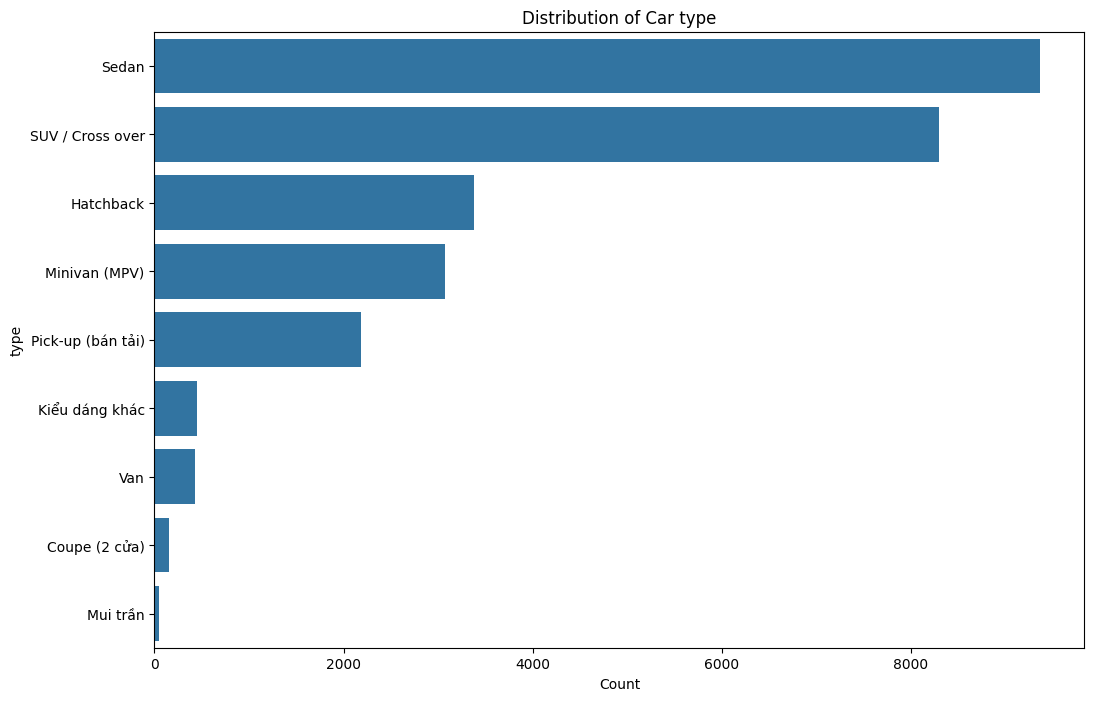

In [89]:
# Print the plot of car type
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='type', order=data['type'].value_counts().index)
plt.title('Distribution of Car type')
plt.xlabel('Count')
plt.ylabel('type')
plt.show()

Sedan and SUV are most populars. Mui Tran isn't that popular, maybe it is expensive and people struggle to afford it.

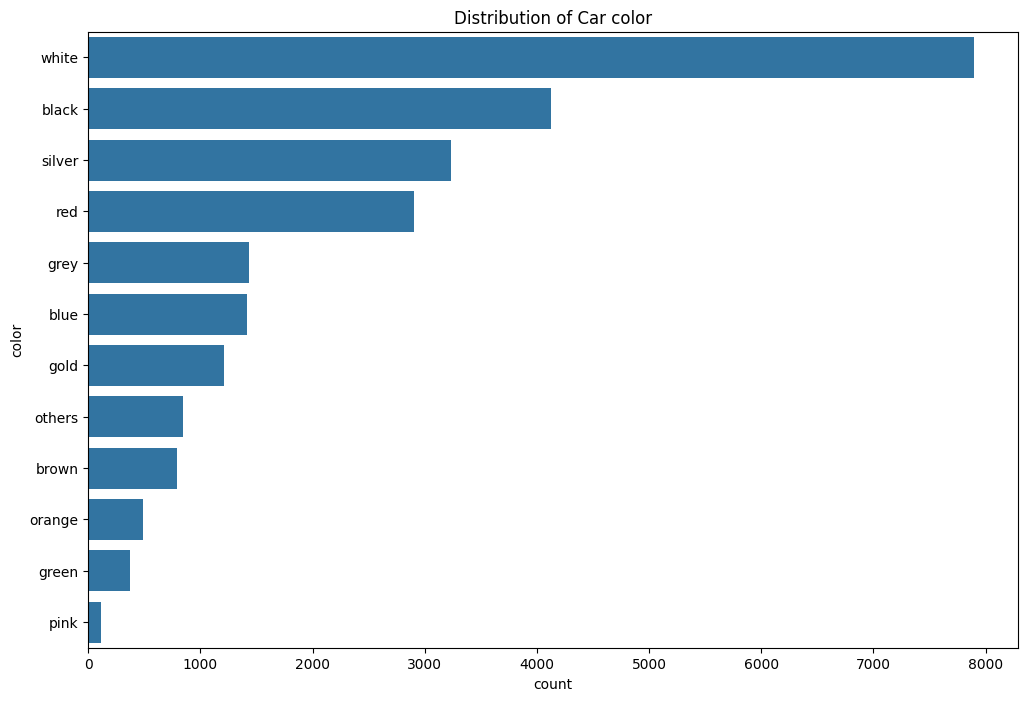

In [90]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='color', order=data['color'].value_counts().index)
plt.title('Distribution of Car color')
plt.ylabel('color')
plt.show()

In [91]:
data['gearbox'].describe()

count     28638
unique        3
top          AT
freq      20911
Name: gearbox, dtype: object

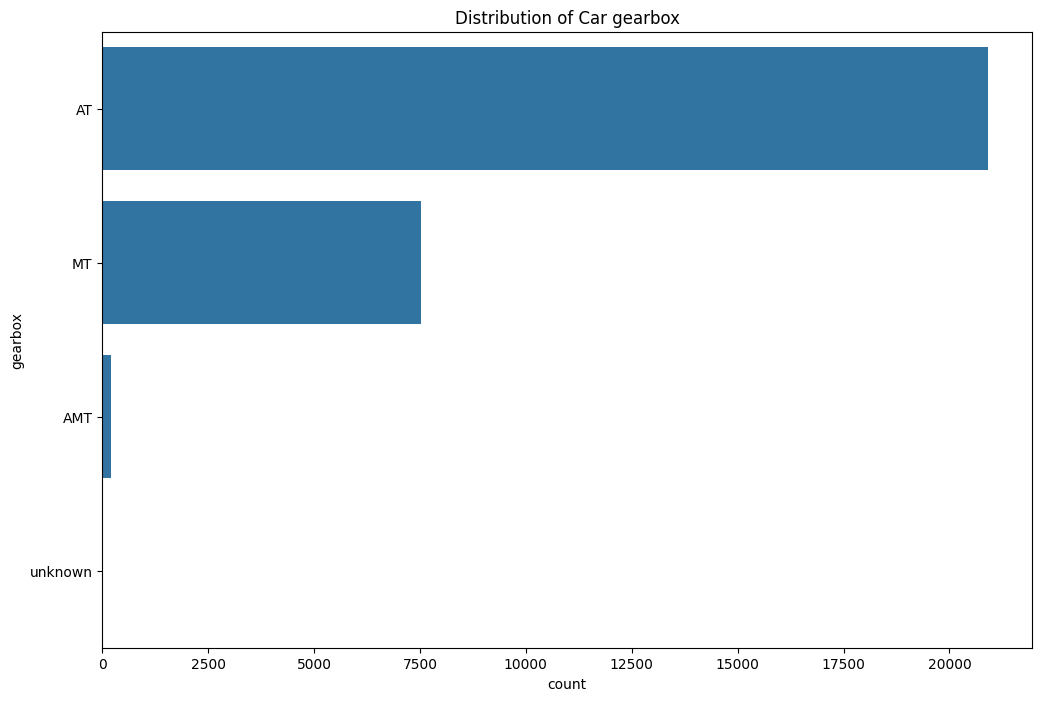

In [92]:
# Print the plot of gearboxes
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='gearbox', order=data['gearbox'].value_counts().index)
plt.title('Distribution of Car gearbox')
plt.ylabel('gearbox')
plt.show()

In [93]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1379,4.795354,category
seats,0,0.000000,float64
gearbox,119,0.413812,category
fuel,0,0.000000,category
color,3927,13.655806,category
mileage_v2,0,0.000000,int64


We will come back to this step after handling potential outliers.

There is nothing much i can do now without having a deep knowledge for cars. Before decide what to do next, I want to make sure if these columns are related to the price, maybe i will try with anova

In [94]:
import stat
import scipy.stats as stats
# List of categorical columns
categorical_columns = ['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']

# copy the og dataframe

stat_data = data.copy()
stat_data = stat_data.dropna()
# Target variable
target = 'price'

# Perform ANOVA for each categorical column
anova_results = {}
for col in categorical_columns:
    groups = [stat_data[target][stat_data[col] == level].dropna() for level in stat_data[col].unique()]
    anova_results[col] = stats.f_oneway(*groups)

# Display the ANOVA results
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-statistic', 'p-value'])
print(anova_df)

           F-statistic        p-value
brand       176.516389   0.000000e+00
model        50.886833   0.000000e+00
origin      191.722049   0.000000e+00
type        216.976947   0.000000e+00
gearbox     880.081216   0.000000e+00
fuel         37.268690   5.090999e-24
color        66.492848  1.998750e-147
condition   479.400398  3.067101e-105


Ok, so basically, when dropping NaN, the model still have the predictive capability. Let see what if we change those nan to unknown and see what happen.

In [95]:
# List of categorical columns
categorical_columns = data.select_dtypes(include=['category', 'object']).columns

# Copy the original dataframe
stat_data = data.copy()

# Convert NaN or Null values to 'Unknown' in categorical columns
for col in categorical_columns:
    stat_data[col] = stat_data[col].astype('category').cat.add_categories('Unknown').fillna('Unknown')

# Target variable
target = 'price'

# Perform ANOVA for each categorical column
anova_results = {}
for col in categorical_columns:
    groups = [stat_data[target][stat_data[col] == level].dropna() for level in stat_data[col].unique()]
    anova_results[col] = stats.f_oneway(*groups)

# Display the ANOVA results
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-statistic', 'p-value'])
print(anova_df)

           F-statistic        p-value
brand       207.316175   0.000000e+00
model        58.342519   0.000000e+00
origin      223.764887   0.000000e+00
type        223.664771   0.000000e+00
gearbox     743.495502   0.000000e+00
fuel         49.963182   3.373017e-32
color        70.317762  2.488736e-170
condition   643.423823  2.110305e-140


Both dropping or changing to unknown both save the day, however, I will stick with dropping, especially when the missing percentage is not large. A p-value being absolute 0 mean that the observed samples are impossible under the null hypothesis (H0: these features has no significant value when calculate the price)

In [96]:
data = data.dropna()

In [97]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.0,int64
brand,0,0.0,category
model,0,0.0,category
origin,0,0.0,category
type,0,0.0,category
seats,0,0.0,float64
gearbox,0,0.0,category
fuel,0,0.0,category
color,0,0.0,category
mileage_v2,0,0.0,int64


### Comback to handling duplicate data

In this step, we have to set out several business logic so that the model's performance align with the business logic. Specifically, for handling suspicious records, we can do the followings:

- Business doesn't sell too old car, therefore very high mileage can be considered to be dropped.

- When mileage=0 and the car condiition is used, consider those records as outliers and vice versa.

- Cars in the same brand/model that are significantly higher than others can also be considered as outliers, thus needed to be eliminated. 

- Different user's perspective need to be carry out, we can calculate the average in such cases.

- Only select brand/model/type that are too the large part. Some high-end car may have very high price, thus the prediction can be vary.

In [98]:
# Drop records where mileage is 0 and condition is 'used'
data = data[~((data['mileage_v2'] <= 0) & (data['condition'] == 'used'))]

# Drop records where mileage is greater than 0 and condition is 'new'
data = data[~((data['mileage_v2'] > 0) & (data['condition'] == 'new'))]

# Display the updated dataframe
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


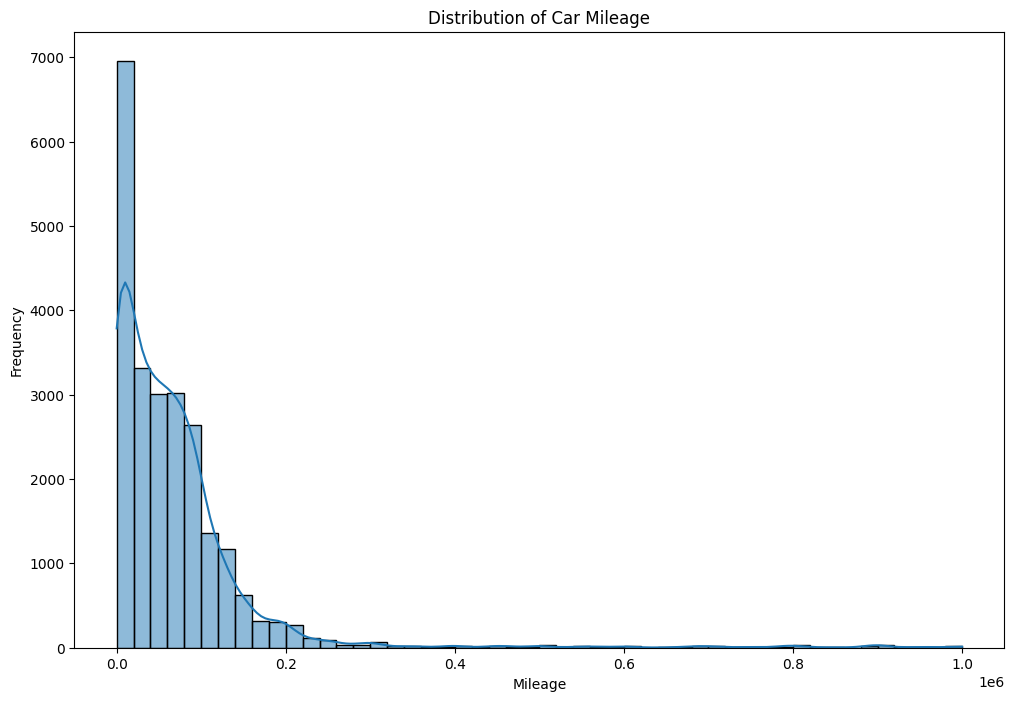

In [99]:
# Remove records that have very high mileage. 
plt.figure(figsize=(12, 8))
sns.histplot(data['mileage_v2'], bins=50, kde=True)
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

In [100]:
# Define the mileage thresholds
thresholds = [0, 0.2e6, 0.4e6, 0.6e6, 0.8e6, 1e6]

# Create a new column 'mileage_category' based on the thresholds
data['mileage_category'] = pd.cut(data['mileage_v2'], bins=thresholds, right=False, labels=['0-0.2e6', '0.2e6-0.4e6', '0.4e6-0.6e6', '0.6e6-0.8e6', '0.8e6-1e6'])

# Calculate the proportion of total cars for each mileage category
mileage_proportion = data['mileage_category'].value_counts(normalize=True).sort_index()

# Calculate the cumulative sum of the proportions
cumulative_sum = mileage_proportion.cumsum()

# Create the dataframe
mileage_cumsum_df = pd.DataFrame({'mileage': cumulative_sum.index, 'cumulative_sum': cumulative_sum.values})

# Display the dataframe
print(mileage_cumsum_df)

       mileage  cumulative_sum
0      0-0.2e6        0.955094
1  0.2e6-0.4e6        0.983854
2  0.4e6-0.6e6        0.989783
3  0.6e6-0.8e6        0.994113
4    0.8e6-1e6        1.000000


We can see that most of the car travel below 0.2e6 km, therefore to avoid outlier, i suggest we remove records with mileage > 0.2e6.

In [101]:
data = data[data['mileage_v2'] <= 0.2e6]
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,mileage_category
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,0-0.2e6
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,0-0.2e6
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,0-0.2e6
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,0-0.2e6
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,0-0.2e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,0-0.2e6
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,0-0.2e6
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,0-0.2e6
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,0-0.2e6


In [102]:
# Calculate the threshold for each brand/model/type combination
thresholds = data.groupby(['brand', 'model', 'type'])['price'].apply(lambda x: x.mean() * 1.3).reset_index()
thresholds.columns = ['brand', 'model', 'type', 'threshold']

# Merge the thresholds with the original data
data_with_thresholds = pd.merge(data, thresholds, on=['brand', 'model', 'type'])

# Filter out the outliers
filtered_data = data_with_thresholds[data_with_thresholds['price'] <= data_with_thresholds['threshold']]

# Drop the threshold column as it's no longer needed
data = filtered_data.drop(columns=['threshold'])

# Display the filtered data
data

/tmp/ipykernel_31947/2905904006.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  thresholds = data.groupby(['brand', 'model', 'type'])['price'].apply(lambda x: x.mean() * 1.3).reset_index()


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,mileage_category
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,0-0.2e6
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,0-0.2e6
2,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,0-0.2e6
3,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,0-0.2e6
5,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,0-0.2e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,0-0.2e6
22910,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,0-0.2e6
22911,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,0-0.2e6
22912,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,0-0.2e6


Ok, so now we have 19700 rows with 13 columns, we can delete the mileage_category columns later. However, we should care about the type of car that took up the most part for each brand. 

In [104]:
# Calculate the count of each brand/model/type combination
brand_model_type_counts = data.groupby(['brand', 'model', 'type']).size().reset_index(name='count')

# Sort the values in descending order
brand_model_type_counts = brand_model_type_counts.sort_values(by='count', ascending=False)

# Calculate the cumulative sum of the counts
brand_model_type_counts['cumulative_sum'] = brand_model_type_counts['count'].cumsum()

# Calculate the total count of cars
total_count = brand_model_type_counts['count'].sum()

# Calculate the cumulative percentage
brand_model_type_counts['cumulative_percentage'] = (brand_model_type_counts['cumulative_sum'] / total_count) * 100

# Select the combinations that make up around 90% of the total cars
selected_combinations = brand_model_type_counts[brand_model_type_counts['cumulative_percentage'] <= 90]

# Select the combinations that make up around 90% of the total cars for each brand
selected_combinations = brand_model_type_counts.groupby('brand').apply(
    lambda x: x[x['cumulative_percentage'] <= 90]
).reset_index(drop=True)

# Display the selected combinations
selected_combinations

/tmp/ipykernel_31947/3803698555.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_model_type_counts = data.groupby(['brand', 'model', 'type']).size().reset_index(name='count')
/tmp/ipykernel_31947/3803698555.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected_combinations = brand_model_type_counts.groupby('brand').apply(
/tmp/ipykernel_31947/3803698555.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to 

,brand,model,type,count,cumulative_sum,cumulative_percentage
0,Audi,Q7,SUV / Cross over,25,16537,83.944162
1,Audi,Q5,SUV / Cross over,24,16659,84.563452
2,Audi,A4,Sedan,17,17244,87.532995
3,BMW,3 Series,Sedan,90,12503,63.467005
4,BMW,5 Series,Sedan,46,15505,78.705584
...,...,...,...,...,...,...
193,Vinfast,VF5,SUV / Cross over,16,17361,88.126904
194,Vinfast,Dòng khác,SUV / Cross over,13,17651,89.598985
195,Volkswagen,Teramont,SUV / Cross over,30,16263,82.553299
196,Volkswagen,Tiguan,SUV / Cross over,24,16635,84.441624


In [106]:
# Merge the data with selected_combinations to filter the records
data = pd.merge(data, selected_combinations[['brand', 'model', 'type']], on=['brand', 'model', 'type'])

# Display the filtered data
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,mileage_category
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,0-0.2e6
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,0-0.2e6
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,0-0.2e6
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,0-0.2e6
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used,0-0.2e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used,0-0.2e6
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,0-0.2e6
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,0-0.2e6
17724,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,0-0.2e6


Ok, so now we have 17726 rows with 13 columns. Finally we can consider merge records with the same features but with different price.

In [107]:
data = data.drop(columns=['mileage_category'])

In [108]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
17724,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [109]:
exp_data = data.copy()

In [110]:
# Define feature cols
feature_cols = ['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'mileage_v2',
 'condition']
# Create a new column by concatenating other columns
exp_data['concatenated'] = exp_data[feature_cols].astype(str).agg('_'.join, axis=1)

# Check for duplicates in the concatenated column but with different prices
duplicates_with_diff_price = exp_data[exp_data.duplicated(subset=['concatenated'], keep=False) & exp_data.duplicated(subset=['concatenated', 'price'], keep=False) == False]

duplicates_with_diff_price[['concatenated', 'price']].sort_values(by='concatenated').tail()

,concatenated,price
5434,2023_Volkswagen_Tiguan_Nước khác_SUV / Cross o...,1.499000e+09
4193,2023_Volkswagen_Tiguan_Nước khác_SUV / Cross o...,1.499000e+09
1672,2023_Volkswagen_Tiguan_Nước khác_SUV / Cross o...,1.699000e+09
5969,2023_Volkswagen_Tiguan_Đức_SUV / Cross over_7....,1.499000e+09
1083,2023_Volkswagen_Tiguan_Đức_SUV / Cross over_7....,1.699000e+09


In [111]:
# Identify duplicates based on the concatenated values
exp_duplicated = duplicates_with_diff_price[duplicates_with_diff_price.duplicated('concatenated', keep=False)]

# Display the duplicate records
exp_duplicated.sort_values(by='concatenated')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
5889,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,3.500000e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
6997,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.500000e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
7807,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.000000e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
3808,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.700000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
4576,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.400000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,2023,Volkswagen,Teramont,Mỹ,SUV / Cross over,7.0,AT,petrol,others,0,2.499000e+09,new,2023_Volkswagen_Teramont_Mỹ_SUV / Cross over_7...
5292,2023,Volkswagen,Teramont,Nước khác,SUV / Cross over,7.0,AT,petrol,blue,0,2.099000e+09,new,2023_Volkswagen_Teramont_Nước khác_SUV / Cross...
4561,2023,Volkswagen,Teramont,Nước khác,SUV / Cross over,7.0,AT,petrol,blue,0,2.249000e+09,new,2023_Volkswagen_Teramont_Nước khác_SUV / Cross...
6083,2023,Volkswagen,Teramont,Đức,SUV / Cross over,7.0,AT,petrol,black,0,2.099000e+09,new,2023_Volkswagen_Teramont_Đức_SUV / Cross over_...


Based on what we have observed, it is safe to say that different people truly sale their car differently eventhough the configuration was the same. Therefore in order to minimize the error, I suggest we group them and take the average of the price. I think this approach is suitable because owners have a more clear view about what car price that they should sell on the market compared to other salers


In [112]:
exp_merge_price = exp_duplicated.groupby('concatenated').agg({'price': 'mean'}).reset_index()

In [113]:
exp_merge_price

,concatenated,price
0,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...,2.666667e+07
1,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...,3.550000e+07
2,1984_Toyota_Corolla_Nhật Bản_Sedan_5.0_MT_petr...,1.950000e+07
3,1987_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol...,4.866667e+07
4,1992_Honda_Accord_Mỹ_Sedan_5.0_MT_petrol_red_1...,6.927700e+07
...,...,...
2547,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...,9.942500e+08
2548,2023_Volkswagen_Teramont_Mỹ_SUV / Cross over_7...,2.174000e+09
2549,2023_Volkswagen_Teramont_Mỹ_SUV / Cross over_7...,2.299000e+09
2550,2023_Volkswagen_Teramont_Nước khác_SUV / Cross...,2.174000e+09


Okay, so far so good, now we have carefully handle records where the same configurations appear frequently. Now we need to merge it with the data, then remove duplicated as before.

In [114]:
data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,2020_Mitsubishi_Xpander_Nước khác_Minivan (MPV...
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used,2015_Toyota_Camry_Việt Nam_Sedan_5.0_AT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used,2016_Kia_K3_Hàn Quốc_Sedan_5.0_AT_petrol_black...
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
17724,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [115]:
# Create a dictionary from exp_merge_price for efficient lookup
price_dict = dict(zip(exp_merge_price['concatenated'], exp_merge_price['price']))
price_dict

{'1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_petrol_blue_200000_used': 26666666.666666668,
 '1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol_blue_123123_used': 35500000.0,
 '1984_Toyota_Corolla_Nhật Bản_Sedan_5.0_MT_petrol_blue_59000_used': 19500000.0,
 '1987_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol_grey_100000_used': 48666666.666666664,
 '1992_Honda_Accord_Mỹ_Sedan_5.0_MT_petrol_red_123456_used': 69277000.0,
 '1992_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol_blue_123456_used': 40868000.0,
 '1992_Toyota_Camry_Nhật Bản_Sedan_5.0_AT_petrol_red_50000_used': 61000000.0,
 '1992_Toyota_Camry_Nhật Bản_Sedan_5.0_AT_petrol_silver_1111_used': 75000000.0,
 '1992_Toyota_Camry_Việt Nam_Sedan_2.0_AT_petrol_white_85000_used': 124250000.0,
 '1993_Toyota_Corolla_Nhật Bản_Sedan_5.0_MT_petrol_grey_195000_used': 68666666.66666667,
 '1994_Hyundai_Sonata_Hàn Quốc_Sedan_5.0_MT_petrol_white_150000_used': 17000000.0,
 '1995_Honda_Accord_Nhật Bản_Sedan_4.0_AT_petrol_green_1_used': 110000000.0,
 '1995_Honda_Accor

In [116]:
another_data = data.copy()
another_data['price'] = another_data['concatenated'].map(price_dict).fillna(another_data['price'])
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,2020_Mitsubishi_Xpander_Nước khác_Minivan (MPV...
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used,2015_Toyota_Camry_Việt Nam_Sedan_5.0_AT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used,2016_Kia_K3_Hàn Quốc_Sedan_5.0_AT_petrol_black...
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
17724,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,310000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [117]:
another_data = another_data.drop_duplicates()
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used,2020_Mitsubishi_Xpander_Nước khác_Minivan (MPV...
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used,2015_Toyota_Camry_Việt Nam_Sedan_5.0_AT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used,2019_Honda_CR V_Thái Lan_SUV / Cross over_5.0_...
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used,2016_Kia_K3_Hàn Quốc_Sedan_5.0_AT_petrol_black...
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...


In [118]:
another_data = another_data.drop('concatenated', axis=1)

In [119]:
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [120]:
another_data.to_csv("data/processed/handled_duplicate_data.csv", index=False)

Ok so there is no more problem with duplicate data. We can move on and deal with missing values

In [121]:
data = another_data.copy()

In [122]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,14126.000000,14126.000000,14126.000000,1.412600e+04
mean,2016.337958,5.566332,60004.784157,5.014392e+08
std,5.532479,1.440092,46437.520209,3.662864e+08
min,1980.000000,2.000000,0.000000,5.000000e+06
25%,2014.000000,5.000000,20999.250000,2.950000e+08
50%,2018.000000,5.000000,55000.000000,4.490000e+08
75%,2020.000000,7.000000,89000.000000,6.000000e+08
max,2023.000000,16.000000,200000.000000,5.750000e+09


In [123]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,14126,14126,14126,14126,14126,14126,14126,14126
unique,24,167,10,8,3,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,2987,756,7516,5043,10354,11756,4319,13383


In [124]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.0,int64
brand,0,0.0,category
model,0,0.0,category
origin,0,0.0,category
type,0,0.0,category
seats,0,0.0,float64
gearbox,0,0.0,category
fuel,0,0.0,category
color,0,0.0,category
mileage_v2,0,0.0,int64


Ok so now we have handling all the missing values, the model can now learn, hope it learn better :)

In [125]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


## Handling outliers

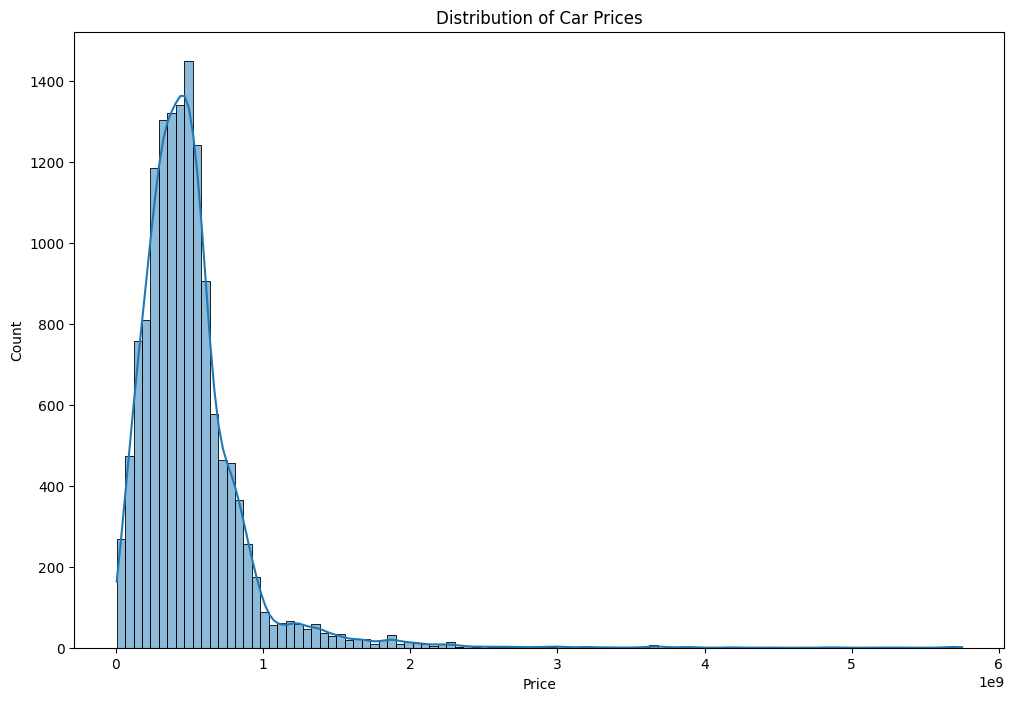

In [126]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='price', bins=100, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that while most of the car is low price, some cars remain to be higher price, which raise awareness on how these model/brand/type have a very high price, therefore what we are going to do is check for those instances, however, we need to identify them first. 

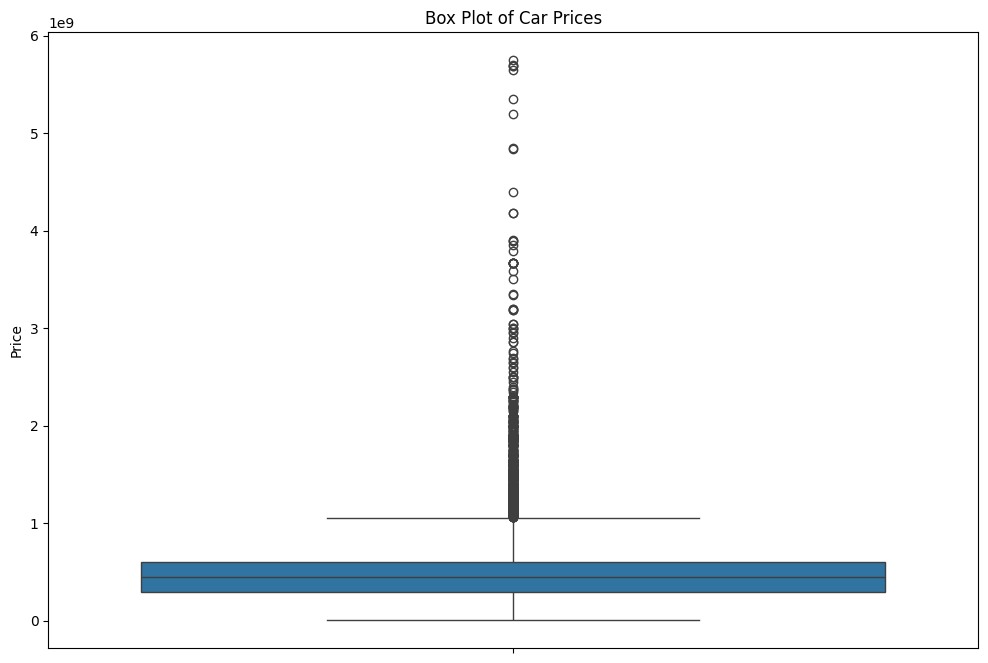

In [127]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, y='price')
plt.title('Box Plot of Car Prices')
plt.ylabel('Price')
plt.show()

In [128]:
# There is lots of outliers in the price column, we can investigate them further, using the IQR method. 
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
outliers

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
130,2019,Mercedes Benz,C Class,Đức,Sedan,5.0,AT,petrol,red,25000,1.268000e+09,used
140,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,blue,13000,1.368000e+09,used
163,2019,Mercedes Benz,E Class,Đức,Sedan,4.0,AT,petrol,white,16000,1.250000e+09,used
173,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,others,13000,1.368000e+09,used
214,2019,Mercedes Benz,C Class,Đức,Sedan,5.0,AT,petrol,black,40000,1.149000e+09,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17036,2021,Mercedes Benz,GLC,Đức,SUV / Cross over,5.0,AT,petrol,red,7000,1.404500e+09,used
17251,2018,Mercedes Benz,GLC Class,Đức,SUV / Cross over,5.0,AT,petrol,black,50000,1.150000e+09,used
17488,2010,Lexus,GX,Nhật Bản,SUV / Cross over,8.0,AT,petrol,green,90000,1.650000e+09,used
17581,2022,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,grey,0,1.090000e+09,new


In [129]:
# percentage of condition in the outlier
outliers['condition'].value_counts(normalize=True) * 100

condition
used    88.774003
new     11.225997
Name: proportion, dtype: float64

In [130]:
data['condition'].value_counts(normalize=True) * 100

condition
used    94.740195
new      5.259805
Name: proportion, dtype: float64

We can see that the ratio for used/new from the outlier versus original data is lower, therefore it is quite right, since new car often have higher price than old car. What if it is the case where the saler overestimate the true value of the car? We need to investigate that at well. We can try and do this by compare the values to the one that is not outlier to see whether they are the same or not. 

In [131]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


# Feature Engineering

As with the objective saying above about the model have to perform correctly for brands that made up to 90% of the total car, with that being said, we should focus on brands that made up to the total of 90% of our car. 

In [132]:
# Calculate the proportion of each brand
brand_counts = data['brand'].value_counts(normalize=True).reset_index()
brand_counts.columns = ['brand', 'proportion']

# Calculate the cumulative sum of the proportions
brand_counts['cumulative_sum'] = brand_counts['proportion'].cumsum()

# Define the cutoff value
cutoff = 0.91
brand_counts_below_cutoff = brand_counts[brand_counts['cumulative_sum'] <= cutoff]

brand_counts_below_cutoff

,brand,proportion,cumulative_sum
0,Toyota,0.211454,0.211454
1,Kia,0.128133,0.339587
2,Ford,0.127566,0.467153
3,Hyundai,0.121690,0.588843
4,Mitsubishi,0.071216,0.660059
5,Mazda,0.067535,0.727595
6,Honda,0.055359,0.782953
7,Mercedes Benz,0.048209,0.831162
8,Chevrolet,0.037449,0.868611
9,Vinfast,0.026759,0.895370


Ok so now we know these brands cummulative up to 90% data in our dataset. The objective is to make the model to learn well on this set. Or focus on this set at least.

In [133]:
data = data[data['brand'].isin(brand_counts_below_cutoff['brand'])]
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


So far so good, we have picked records that belong to certain brand.

In [134]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [135]:
data.to_csv("data/processed/handled_duplicate_missing_data.csv", index=False)

In [136]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


So far so good, let move on to how can we transform mileage_v2.

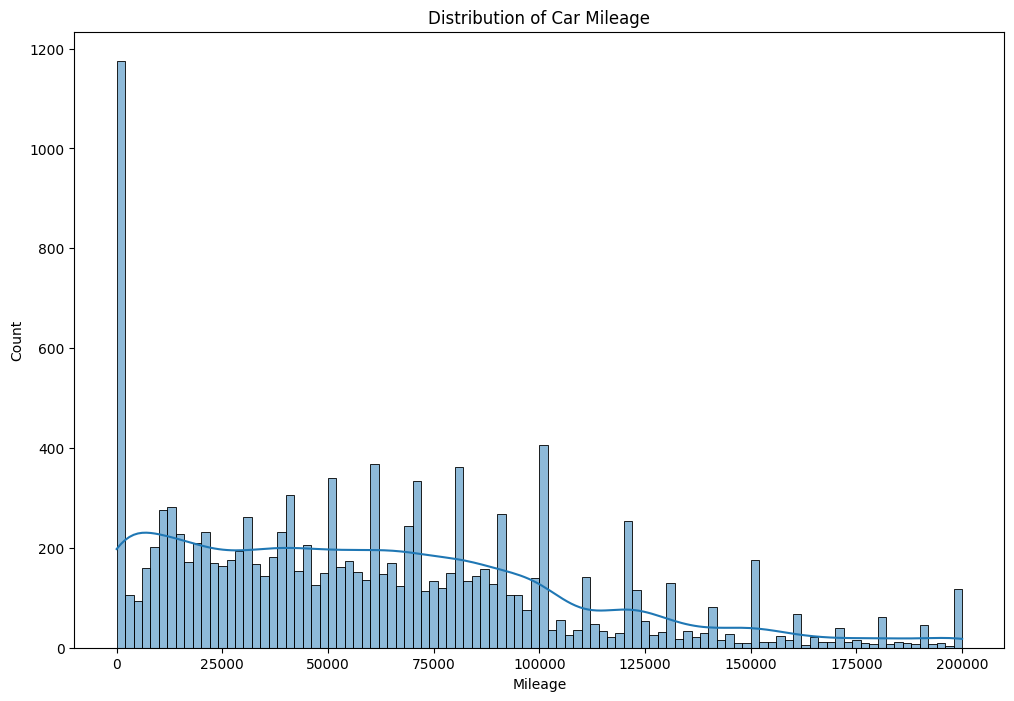

In [137]:
# Visualize the mileage distribution
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='mileage_v2', bins=100, kde=True)
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.show()


This is heavily skewed, we need to investigate it as well

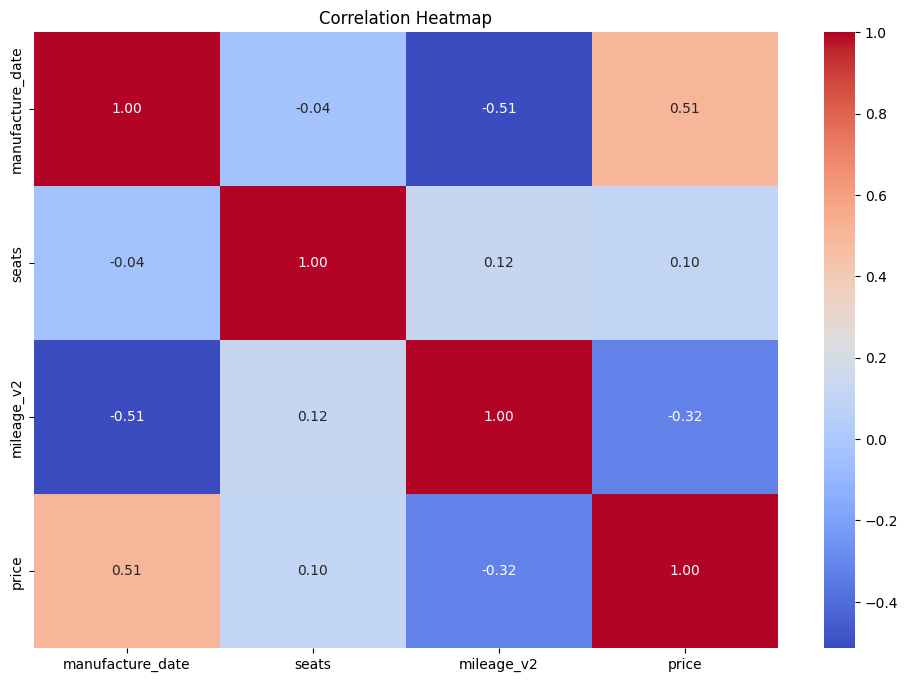

In [138]:
# Visualize the correlation between the numerical columns with the target variable
# Select numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data=data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Price is correlate with manufacture_data positively because of price, this may be because of new cars are more expensive. Additionally, mileage also have a negative correlation with price, maybe because when we travel more, the car become less valuable. Remember that this is solely based on number since correlation does not impose causalation

### Back to handling outlier

In [139]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [140]:
# Create a dictionary to store unique models for each brand
outlier_data = data.copy()
brand_models_dict = {}

# Loop through each brand in brand_counts_below_cutoff
for brand in brand_counts_below_cutoff['brand']:
    unique_models = outlier_data[outlier_data['brand'] == brand]['model'].unique()
    brand_models_dict[brand] = unique_models.tolist()

brand_models_dict


{'Toyota': ['Vios',
  'Camry',
  'Avanza',
  'Fortuner',
  'Veloz',
  'Zace',
  'Innova',
  'Veloz Cross',
  'Corolla Cross',
  'Yaris',
  'Raize',
  'Wigo',
  'Corolla Altis',
  'Hilux',
  'Corolla',
  'Rush',
  'Hiace',
  'Venza',
  'Sienna',
  'RAV4',
  'Land Cruiser',
  'Prado',
  'Land Cruiser Prado'],
 'Kia': ['Soluto',
  'Cerato',
  'Morning',
  'Forte',
  'Rondo',
  'Carnival',
  'K3',
  'Rio',
  'Seltos',
  'Sorento',
  'Carens',
  'K5',
  'CD5',
  'Optima',
  'Sportage',
  'Sedona',
  'Sonet'],
 'Ford': ['Ranger',
  'Focus',
  'Everest',
  'Escape',
  'Transit',
  'Laser',
  'Fiesta',
  'EcoSport',
  'Explorer',
  'Tourneo',
  'Mondeo',
  'Territory',
  'Dòng khác'],
 'Hyundai': ['Elantra',
  'Accent',
  'Creta',
  'Grand i10',
  'Getz',
  'Genesis',
  'Tucson',
  'Santa Fe',
  'Sonata',
  'i20',
  'Veloster',
  'Kona',
  'Avante',
  'Stargazer',
  'i30',
  'Grand Starex'],
 'Mitsubishi': ['Xpander',
  'Attrage',
  'Pajero',
  'Jolie',
  'Xpander Cross',
  'Mirage',
  'Outlan

In [141]:
# # Create a new column for color based on condition
# outlier_data['color'] = outlier_data['condition'].apply(lambda x: 'red' if x == 'new' else 'blue')

# # Loop through each brand and create a scatter plot
# for brand, models in brand_models_dict.items():
#     brand_data = outlier_data[outlier_data['brand'] == brand]
#     brand_data['model'] = brand_data['model'].astype('object')
    
#     plt.figure(figsize=(20, 10))
#     sns.scatterplot(data=brand_data, x='model', y='price', hue='condition', palette=['blue', 'red'], s=100)
    
#     # Customize the plot
#     plt.title(f'{brand} - Model and Price Scatter Plot')
#     plt.xlabel('Model')
#     plt.ylabel('Price')
#     plt.legend(title='Condition')
#     plt.xticks(rotation=90)  # Rotate x-axis labels vertically
#     plt.grid(False)  # Remove the grid
    
#     # Show the plot
#     plt.show()

We can see that each brand has model that is significantly higher than other, eventhough they are in the same model. This maybe outlier, however, I am not an expert, my approach is to leave these outlier alone. Which may be affect to the model's prediction power.

I don't know how to deal with this yet. However, let it be for now and focus on how each columns is related to the target columns.

In [142]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
17721,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
17722,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
17723,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


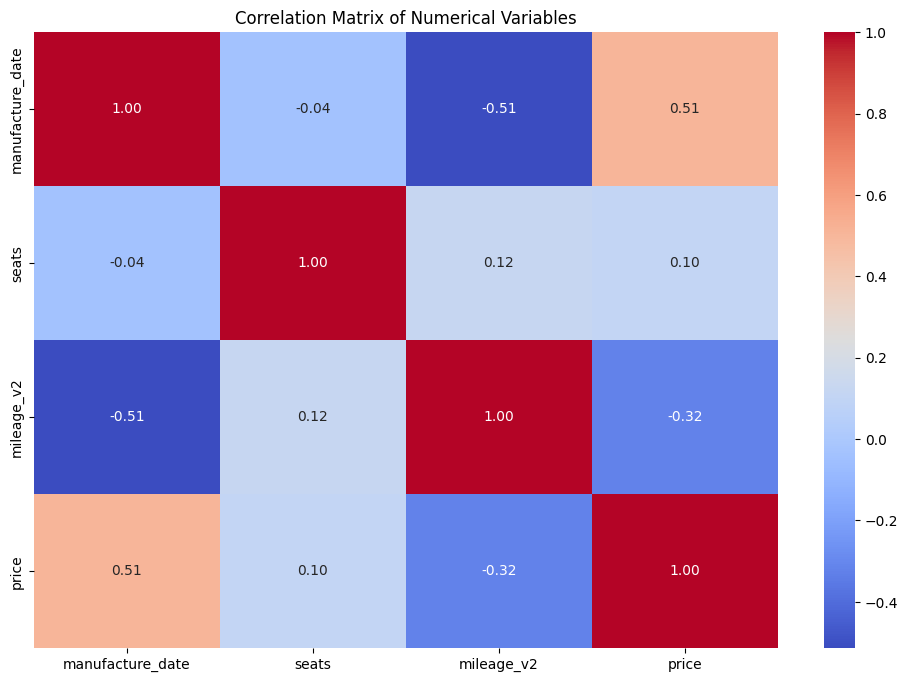

In [143]:

correlation_matrix = data.select_dtypes(np.number).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [144]:
# The following code is for encoding the categorical columns using LabelEncoder
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_columns = ['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']

# Initialize the LabelEncoder
label_encoders = {}

# Copy the original dataframe
encoded_data = data.copy()

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

encoded_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,2,27,2,6,5.0,1,3,11,23000,455000000.0,1
1,2020,8,113,6,6,5.0,2,3,11,99999,368000000.0,1
2,2022,3,38,6,6,5.0,1,3,11,45000,455000000.0,1
3,2020,7,115,3,3,7.0,2,3,11,50000,465000000.0,1
4,2015,8,22,6,6,5.0,1,3,0,70000,580000000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17720,2019,2,17,4,5,5.0,1,3,11,57000,850000000.0,1
17721,2016,4,64,0,6,5.0,1,3,0,64936,460000000.0,1
17722,2019,3,6,6,6,5.0,2,3,10,12000,350000000.0,1
17723,2017,4,90,6,3,7.0,1,2,11,140000,730000000.0,1


In [145]:
import joblib

# Save the label encoder
joblib.dump(le, f'{MODEL_PATH}/label_encoder.joblib')

['models/label_encoder.joblib']

Now we have to adopt new problems:

- In some cases, for example, for the same brand/model/type/.../color, with difference mileage, we still have different price. Which lead to scenario where even with higher mileage, we still facing higher price (the same product), which is not right. Keeping everything the same, when increase the mileage, the price of the car must drop, due to the negative relationship between them. The model need to address this problem.

In [3]:
from api.preprocess import drop_unncessary_columns, cast_to_category, encode_cat_cols, convert_data_dmatrix
from api.constants import CAT_COLS, NUM_COLS, COLS_TO_CAST, COLS_TO_CAST, SAMPLE_DATA

In [6]:
data = pd.read_csv(f"data/processed/handled_duplicate_missing_data.csv")
data = cast_to_category(data, CAT_COLS)
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
1,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
2,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
3,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
4,2015,Toyota,Camry,Việt Nam,Sedan,5.0,AT,petrol,black,70000,580000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
12643,2019,Honda,CR V,Thái Lan,SUV / Cross over,5.0,AT,petrol,white,57000,850000000.0,used
12644,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
12645,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
12646,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [13]:
# Define feature cols
feature_cols = ['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'condition']

# Create a new column by concatenating other columns
data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)

# Create new dataframe with concatenated, mileage and price columns
grouped_df = data[['concatenated', 'mileage_v2', 'price']]

# Group by concatenated and sort by mileage
data = data.sort_values(['concatenated', 'mileage_v2'])

# Display the results
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used,1980_Mazda_626_Nhật Bản_Sedan_5.0_MT_petrol_bl...
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used,1980_Toyota_Hiace_Nhật Bản_Van_6.0_MT_petrol_g...
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used,1980_Toyota_Hiace_Việt Nam_Van_6.0_MT_oil_gree...
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...


In [14]:
# Define feature cols
feature_cols = ['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'condition']

# Create a new column by concatenating other columns
data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)

# Create new dataframe with concatenated, mileage and price columns
grouped_df = data[['concatenated', 'mileage_v2', 'price']]

# Group by concatenated and sort by mileage
grouped_df = data.sort_values(['concatenated', 'mileage_v2'])

# Display the results
grouped_df

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used,1980_Mazda_626_Nhật Bản_Sedan_5.0_MT_petrol_bl...
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used,1980_Toyota_Hiace_Nhật Bản_Van_6.0_MT_petrol_g...
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used,1980_Toyota_Hiace_Việt Nam_Van_6.0_MT_oil_gree...
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...


In [15]:
# Group by concatenated and count unique values
grouped_counts = grouped_df.groupby('concatenated').size()

# Get concatenated values that appear more than once
multi_occurrence = grouped_counts[grouped_counts > 1].index

# Filter the dataframe to only include rows with concatenated values that appear multiple times
filtered_df = grouped_df[grouped_df['concatenated'].isin(multi_occurrence)]

# Group by concatenated and check if there are different mileage or price values
has_diff = filtered_df.groupby('concatenated').agg({
    'mileage_v2': lambda x: len(x.unique()) > 1,
    'price': lambda x: len(x.unique()) > 1
})

# Get concatenated values where either mileage or price differs
diff_records = has_diff[has_diff['mileage_v2'] | has_diff['price']].index

# Filter to get only records with differences
final_df = filtered_df[filtered_df['concatenated'].isin(diff_records)]

# Sort by concatenated and mileage for better visualization
final_df = final_df.sort_values(['concatenated', 'mileage_v2'])

# Display results
print(f"Found {len(diff_records)} unique combinations with differences")
final_df


Found 2155 unique combinations with differences


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2690,1987,Toyota,Camry,Nhật Bản,Sedan,5.0,MT,petrol,white,50000,4.000000e+07,used,1987_Toyota_Camry_Nhật Bản_Sedan_5.0_MT_petrol...
9750,1987,Toyota,Camry,Nhật Bản,Sedan,5.0,MT,petrol,white,150000,6.800000e+07,used,1987_Toyota_Camry_Nhật Bản_Sedan_5.0_MT_petrol...
2189,1992,Honda,Accord,Nhật Bản,Sedan,5.0,MT,petrol,blue,10000,3.300000e+07,used,1992_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol...
2278,1992,Honda,Accord,Nhật Bản,Sedan,5.0,MT,petrol,blue,123456,4.086800e+07,used,1992_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol...
11596,1992,Toyota,Camry,Nhật Bản,Sedan,5.0,AT,petrol,red,50000,6.100000e+07,used,1992_Toyota_Camry_Nhật Bản_Sedan_5.0_AT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,1200,4.466667e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
902,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,1250,4.483333e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
4760,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,7000,4.320000e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
90,2023,Toyota,Wigo,Nước khác,Hatchback,5.0,AT,petrol,white,50,1.500000e+08,used,2023_Toyota_Wigo_Nước khác_Hatchback_5.0_AT_pe...


So there are about 8000 records (over 12000 records) that is approximately 2/3 of the data seeing this situation. This is a little bit odd. Which may increase the probability that we will do something wrong. Now we have to exclude records that have lower milleage but lower price or higher mileage but higher price. 

Also remember that we are trying to **apply monotonic constraint on the mileage_v2 variable**. However, the **data show that this feature is not follow a monotonic constraint**. We must address this problem as well.

I have think about several things we could do to address this problem:

1. We will keep everything the same, then adjust by ranking of mileage and price. With that being said, keep everything the same, records with highest mileage will have the lowest price. 

In [16]:
# Group by concatenated to find duplicates
duplicates = final_df.groupby('concatenated').agg({
    'mileage_v2': list,
    'price': list
}).reset_index()

# Count how many records need adjustment
records_to_adjust = 0

# For each group of duplicates, ensure price decreases as mileage increases
for idx, row in duplicates.iterrows():
    mileages = row['mileage_v2']
    prices = row['price']
    
    # Sort mileages and prices
    sorted_pairs = sorted(zip(mileages, prices), key=lambda x: x[0])
    sorted_mileages, sorted_prices = zip(*sorted_pairs)
    
    # Check if prices need adjustment (should decrease as mileage increases)
    needs_adjustment = False
    for i in range(len(sorted_prices)-1):
        if sorted_prices[i] < sorted_prices[i+1]:
            needs_adjustment = True
            records_to_adjust += 1
            break
            
    if needs_adjustment:
        # Replace prices with monotonically decreasing values
        # Use the lowest price for highest mileage
        sorted_prices = sorted(prices, reverse=True)
        
        # Update the original dataframe
        for mileage, price in zip(sorted_mileages, sorted_prices):
            mask = (final_df['concatenated'] == row['concatenated']) & (final_df['mileage_v2'] == mileage)
            final_df.loc[mask, 'price'] = price

print(f"Adjusted prices for {records_to_adjust} groups of records to ensure monotonic relationship")

# Verify the adjustment worked
verification = final_df.groupby('concatenated').apply(
    lambda x: x.sort_values('mileage_v2')['price'].is_monotonic_decreasing
).mean() * 100

print(f"{verification:.2f}% of groups now have monotonically decreasing prices with increasing mileage")


Adjusted prices for 1387 groups of records to ensure monotonic relationship
100.00% of groups now have monotonically decreasing prices with increasing mileage


/tmp/ipykernel_2430/306158683.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  verification = final_df.groupby('concatenated').apply(


In [17]:
final_df

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2690,1987,Toyota,Camry,Nhật Bản,Sedan,5.0,MT,petrol,white,50000,6.800000e+07,used,1987_Toyota_Camry_Nhật Bản_Sedan_5.0_MT_petrol...
9750,1987,Toyota,Camry,Nhật Bản,Sedan,5.0,MT,petrol,white,150000,4.000000e+07,used,1987_Toyota_Camry_Nhật Bản_Sedan_5.0_MT_petrol...
2189,1992,Honda,Accord,Nhật Bản,Sedan,5.0,MT,petrol,blue,10000,4.086800e+07,used,1992_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol...
2278,1992,Honda,Accord,Nhật Bản,Sedan,5.0,MT,petrol,blue,123456,3.300000e+07,used,1992_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol...
11596,1992,Toyota,Camry,Nhật Bản,Sedan,5.0,AT,petrol,red,50000,1.250000e+08,used,1992_Toyota_Camry_Nhật Bản_Sedan_5.0_AT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,1200,4.483333e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
902,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,1250,4.466667e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
4760,2023,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,7000,4.320000e+08,used,2023_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
90,2023,Toyota,Wigo,Nước khác,Hatchback,5.0,AT,petrol,white,50,1.500000e+08,used,2023_Toyota_Wigo_Nước khác_Hatchback_5.0_AT_pe...


In [18]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used,1980_Mazda_626_Nhật Bản_Sedan_5.0_MT_petrol_bl...
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used,1980_Toyota_Hiace_Nhật Bản_Van_6.0_MT_petrol_g...
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used,1980_Toyota_Hiace_Việt Nam_Van_6.0_MT_oil_gree...
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...


Now we will map the price of the price_df back to data, the mapping will be processed by 2 columns, the concatenated and the mileage_v2

In [20]:
# Create a mapping dictionary using concatenated and mileage_v2 as composite key
price_mapping = final_df.set_index(['concatenated', 'mileage_v2'])['price'].to_dict()

# Map prices back to data using the composite key
data['price'] = data.apply(lambda row: price_mapping.get((row['concatenated'], row['mileage_v2']), row['price']), axis=1)

data


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used,1980_Mazda_626_Nhật Bản_Sedan_5.0_MT_petrol_bl...
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used,1980_Toyota_Hiace_Nhật Bản_Van_6.0_MT_petrol_g...
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used,1980_Toyota_Hiace_Việt Nam_Van_6.0_MT_oil_gree...
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...


In [21]:
data.drop_duplicates()

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used,1980_Mazda_626_Nhật Bản_Sedan_5.0_MT_petrol_bl...
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used,1980_Toyota_Hiace_Nhật Bản_Van_6.0_MT_petrol_g...
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used,1980_Toyota_Hiace_Việt Nam_Van_6.0_MT_oil_gree...
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new,2023_Vinfast_VF8_Việt Nam_SUV / Cross over_5.0...


In [22]:
data.drop(columns='concatenated', inplace=True)

In [23]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used
...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new


Ok, but to make sure, we need to calculate the correlation heatmap

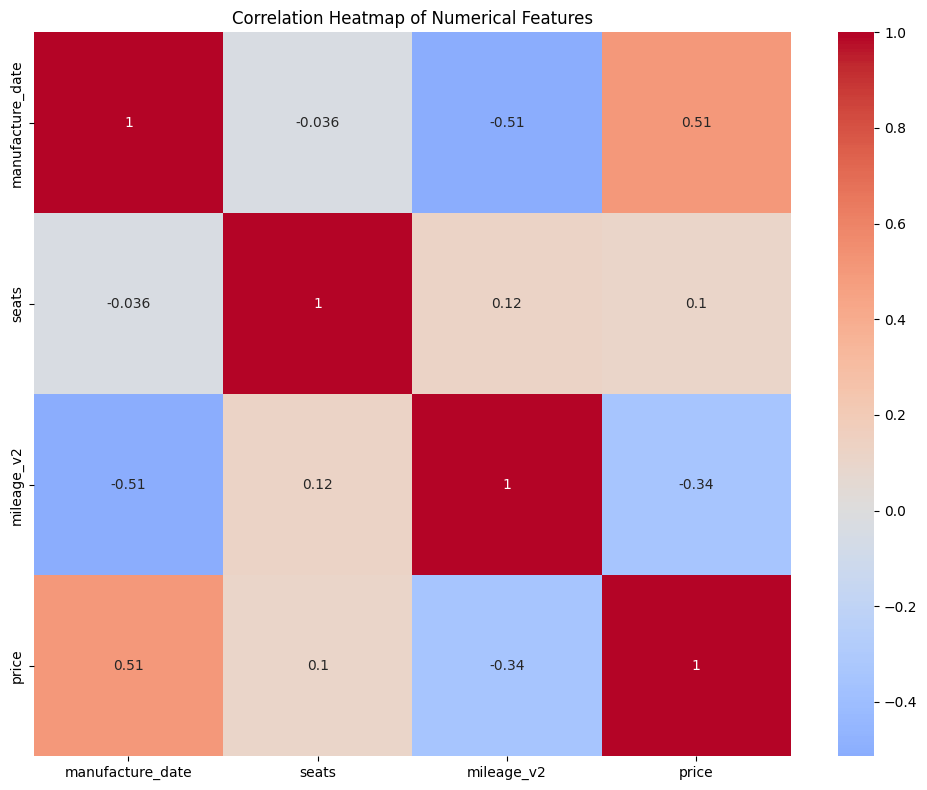

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_data = data.select_dtypes(include=np.number)

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


# Modeling and Evaluation

I will try with catboost, lgbm, xgboost and other regression models as well.

## Train and split test

In [147]:
# # Define the features and target variable
# X = encoded_data.drop(columns=['price'])
# y = encoded_data['price']

# # Split the data into training and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=42)

# # Split the temporary set into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Print the shapes of the resulting datasets
# print(f'Training set: {X_train.shape}, {y_train.shape}')
# print(f'Validation set: {X_val.shape}, {y_val.shape}')
# print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (12015, 11), (12015,)
Validation set: (316, 11), (316,)
Test set: (317, 11), (317,)


In [148]:
# # Save the train, validation, and test sets to the specified directory
# X_train.to_csv(f"{DATA_PATH}/processed/X_train.csv", index=False)
# X_val.to_csv(f"{DATA_PATH}/processed/X_val.csv", index=False)
# X_test.to_csv(f"{DATA_PATH}/processed/X_test.csv", index=False)
# y_train.to_csv(f"{DATA_PATH}/processed/y_train.csv", index=False)
# y_val.to_csv(f"{DATA_PATH}/processed/y_val.csv", index=False)
# y_test.to_csv(f"{DATA_PATH}/processed/y_test.csv", index=False)

# Save the train, validation, and test sets to the specified directory with '_encoded' suffix
# X_train.to_csv(f"{DATA_PATH}/processed/X_train_encoded.csv", index=False)
# X_val.to_csv(f"{DATA_PATH}/processed/X_val_encoded.csv", index=False)
# X_test.to_csv(f"{DATA_PATH}/processed/X_test_encoded.csv", index=False)
# y_train.to_csv(f"{DATA_PATH}/processed/y_train_encoded.csv", index=False)
# y_val.to_csv(f"{DATA_PATH}/processed/y_val_encoded.csv", index=False)
# y_test.to_csv(f"{DATA_PATH}/processed/y_test_encoded.csv", index=False)

In [26]:
# Define the features and target variable
X = data.drop(columns=['price'])
y = data['price']

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

# Save the train, validation, and test sets to the specified directory
X_train.to_csv(f"{DATA_PATH}/processed/X_train_monotonic.csv", index=False)
X_val.to_csv(f"{DATA_PATH}/processed/X_val_monotonic.csv", index=False)
X_test.to_csv(f"{DATA_PATH}/processed/X_test_monotonic.csv", index=False)
y_train.to_csv(f"{DATA_PATH}/processed/y_train_monotonic.csv", index=False)
y_val.to_csv(f"{DATA_PATH}/processed/y_val_monotonic.csv", index=False)
y_test.to_csv(f"{DATA_PATH}/processed/y_test_monotonic.csv", index=False)

Training set: (12015, 11), (12015,)
Validation set: (316, 11), (316,)
Test set: (317, 11), (317,)


In [4]:
X_train_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_train_encoded.csv")
X_val_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_val_encoded.csv")
X_test_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_test_encoded.csv")
y_train_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_train_encoded.csv")
y_val_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_val_encoded.csv")
y_test_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_test_encoded.csv")
# # For original data
X_train = pd.read_csv(f"{DATA_PATH}/processed/X_train.csv")
X_val = pd.read_csv(f"{DATA_PATH}/processed/X_val.csv")
X_test = pd.read_csv(f"{DATA_PATH}/processed/X_test.csv")
y_train = pd.read_csv(f"{DATA_PATH}/processed/y_train.csv")
y_val = pd.read_csv(f"{DATA_PATH}/processed/y_val.csv")
y_test = pd.read_csv(f"{DATA_PATH}/processed/y_test.csv")


In [5]:
# # Define the features and target variable
# X = data.drop(columns=['price'])
# y = data['price']

# # Split the data into training and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# # Split the temporary set into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

# Print the shapes of encoded datasets
print(f"Training set: {X_train_encoded.shape}, {y_train_encoded.shape}")
print(f"Validation set: {X_val_encoded.shape}, {y_val_encoded.shape}")
print(f"Test set: {X_test_encoded.shape}, {y_test_encoded.shape}")


Training set: (12015, 11), (12015, 1)
Validation set: (316, 11), (316, 1)
Test set: (317, 11), (317, 1)
Training set: (12015, 11), (12015, 1)
Validation set: (316, 11), (316, 1)
Test set: (317, 11), (317, 1)


We load the encoded version for catboost and lgbm. The original version for XGBoost

## Try with the baseline first
What we are going to do to establish a baseline is to build a simple model

### XGBoost

In [27]:
# Convert object columns in X_train, X_val, and X_test to category
X_train = cast_to_category(X_train, CAT_COLS)
X_val = cast_to_category(X_val, CAT_COLS)
X_test = cast_to_category(X_test, CAT_COLS)

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, missing=np.NAN)
dval= xgb.DMatrix(X_val, label=y_val, enable_categorical=True, missing=np.NAN)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True, missing=np.NAN)

Since XGBoost need to specify to allow NaN, we have to create NaN for it as well.

In [78]:
xgb_params = {
    'objective': 'reg:absoluteerror',  
    'max_depth': 15,
    'eta': 0.5,
    'enable_categorical': True,
    "n_estimators": 5000,
    "reg_lambda": 1,
    'monotone_constrains':{
        'mileage_v2': -1
    },
    "random_state": 42
}

/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:56:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "monotone_constrains", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 1.1617931592424604e+16
R^2 Score: 0.9059022613705388
Mean Absolute Error: 43232092.47160884


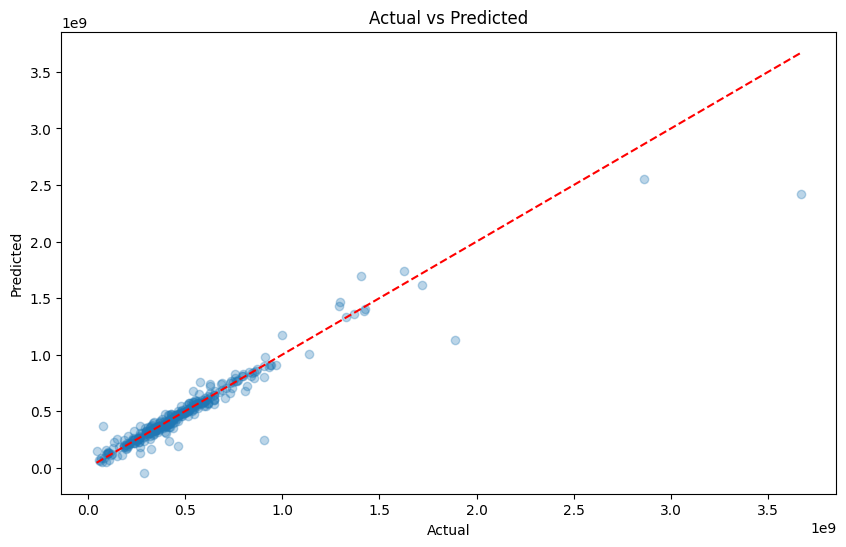

In [79]:
xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=500, evals=[(dval, 'eval')], verbose_eval=0)
# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [80]:
xgb_model.save_model(f'{MODEL_PATH}/xgb_model.json')

In [81]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
2985,1980,Mazda,626,Nhật Bản,Sedan,5.0,MT,petrol,blue,99999,2.000000e+07,used
4321,1980,Mercedes Benz,E Class,Đức,Sedan,5.0,MT,petrol,blue,200000,2.666667e+07,used
2958,1980,Toyota,Hiace,Nhật Bản,Van,6.0,MT,petrol,green,123456,1.780000e+08,used
3061,1980,Toyota,Hiace,Việt Nam,Van,6.0,MT,oil,green,123456,1.980000e+08,used
3031,1983,Toyota,Camry,Nhật Bản,Sedan,4.0,MT,petrol,blue,123123,3.550000e+07,used
...,...,...,...,...,...,...,...,...,...,...,...,...
363,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,orange,0,9.485000e+08,new
8038,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,others,0,1.090000e+09,new
557,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,red,0,1.023500e+09,new
460,2023,Vinfast,VF8,Việt Nam,SUV / Cross over,5.0,AT,electric,white,0,9.942500e+08,new


In [82]:
test_instance = pd.DataFrame({
    'manufacture_date': [2011],
    'brand': ['Ford'],
    'model': ['Fiesta'],
    'origin': ['Thái Lan'],
    'type': ['Hatchback'],
    'seats': [5.0],
    'gearbox': ['AT'],
    'fuel': ['petrol'],
    'color': ['white'],
    'mileage_v2': [10000],
    'condition': ['used']
})
test_instance = cast_to_category(test_instance,CAT_COLS)
test_dmatrix = xgb.DMatrix(test_instance,enable_categorical=True)

prediction = xgb_model.predict(test_dmatrix)


print(f"Predicted price: {prediction[0]:,.0f} VND")

# Compare with actual price from your dataset
actual_price = record['price'].values[0]
print(f"Actual price: {actual_price:,.0f} VND")
print(f"Difference: {abs(prediction[0] - actual_price):,.0f} VND")
print(f"Percentage difference: {abs(prediction[0] - actual_price) / actual_price * 100:.2f}%")

Predicted price: 594,326,208 VND
Actual price: 235,000,000 VND
Difference: 359,326,208 VND
Percentage difference: 152.90%


The result is quite ok, the R^2 is quite high tho. Let move on to catboost

In [32]:
categorical_features = X_train.select_dtypes(include='category').columns.tolist()
print(categorical_features)

['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']


In [37]:
from catboost import CatBoostRegressor, Pool
categorical_features = X_train.select_dtypes(include='category').columns.tolist()
print(categorical_features)
# Create Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)


['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']


In [38]:
# Print all columns 
cols = X_train.columns.to_list()
cols

['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'mileage_v2',
 'condition']

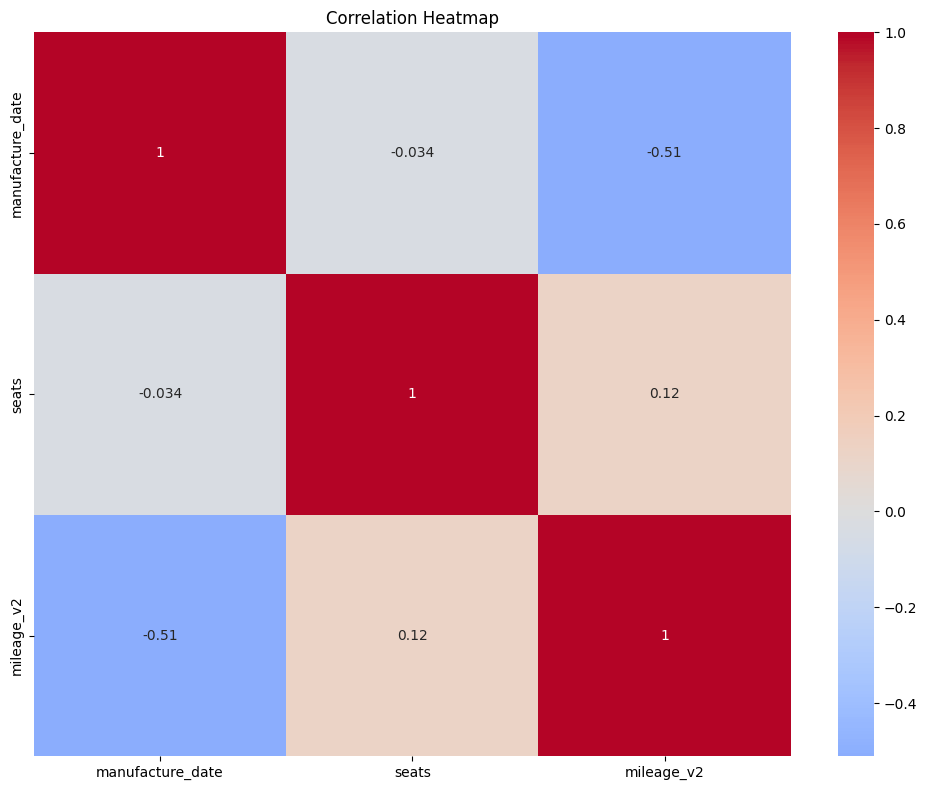

In [39]:
#Print the correlation of the training set towar price
import seaborn as sns
import matplotlib.pyplot as plt
num_data = X_train.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(num_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### CatBoost

In [84]:
# Define the model params
cat_params = {
    'loss_function': 'RMSE',
    'iterations': 4000,
    'learning_rate': 0.2,
    'cat_features': categorical_features,
    'max_depth': 13,
    'verbose': 100,
    'monotone_constraints': {
        'mileage_v2': -1}
}

Notice that monotone constraint can only be use if the loss function is differentiable.

In [85]:
# Train the model
model = CatBoostRegressor(**cat_params)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=300)

# Predict on the test set
y_pred = model.predict(test_pool)

0:	learn: 266477786.4682837	test: 236522076.8956691	best: 236522076.8956691 (0)	total: 3.31s	remaining: 3h 40m 26s
100:	learn: 47018780.5067914	test: 49585870.5756072	best: 49477728.3793447 (99)	total: 2m 5s	remaining: 1h 20m 46s
200:	learn: 35962497.2105846	test: 48325896.7267097	best: 48313014.8856796 (197)	total: 3m 51s	remaining: 1h 12m 52s
300:	learn: 32062346.1384123	test: 48910919.3931576	best: 48206060.0497547 (240)	total: 5m 45s	remaining: 1h 10m 40s
400:	learn: 30275660.6498300	test: 49974845.5577344	best: 48206060.0497547 (240)	total: 7m 27s	remaining: 1h 6m 58s
500:	learn: 29245686.7424803	test: 50200321.1689096	best: 48206060.0497547 (240)	total: 9m 25s	remaining: 1h 5m 50s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 48206060.05
bestIteration = 240

Shrink model to first 241 iterations.


Mean Squared Error: 29276467913046668.00
R^2 Score: 0.7628795277575953
Mean Absolute Error: 150885891.00


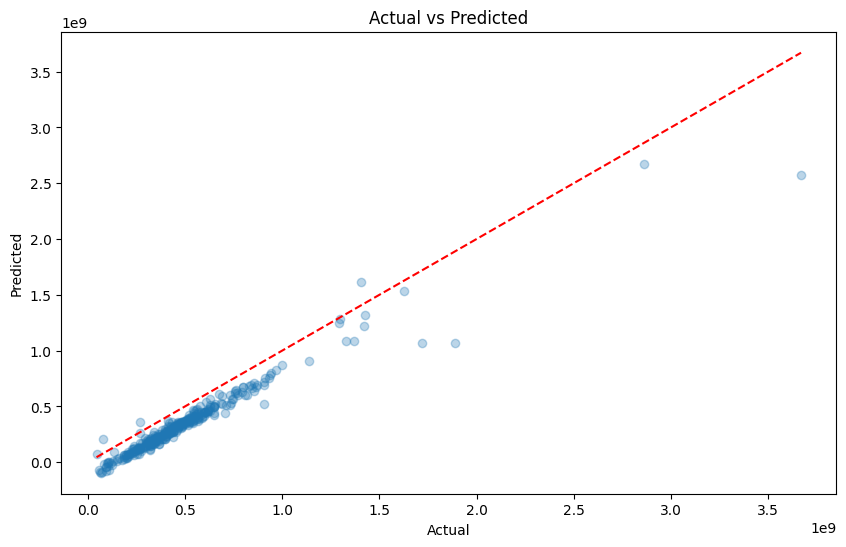

In [86]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae:.2f}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

We may add some bias, or further processing data

So basically, catboost using it own feature encode is better

In [87]:
model.save_model(f'{MODEL_PATH}/catboost_model_autoencode.cbm')

Hmmmmm, not that good, move on to lgbm

### LightGBM

In [3]:

X_train = pd.read_csv(f"{DATA_PATH}/processed/X_train_monotonic.csv")
y_train = pd.read_csv(f"{DATA_PATH}/processed/y_train_monotonic.csv")
X_test = pd.read_csv(f"{DATA_PATH}/processed/X_test_monotonic.csv") 
y_test = pd.read_csv(f"{DATA_PATH}/processed/y_test_monotonic.csv")
X_val = pd.read_csv(f"{DATA_PATH}/processed/X_val_monotonic.csv")
y_val = pd.read_csv(f"{DATA_PATH}/processed/y_val_monotonic.csv")

# Create encoded versions for LightGBM
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
y_train_encoded = y_train.copy()
y_test_encoded = y_test.copy()
X_val_encoded = X_val.copy()
y_val_encoded = y_val.copy()


In [7]:
# lgbm doesnt accept dict as mono constraint like the above, only approve list (in order w feats)
monotonic_constraints = []
for col in X_train_encoded.columns:
    if col == 'manufacture_date':
        monotonic_constraints.append(1)
    elif col == 'mileage_v2':
        monotonic_constraints.append(-1)
    else:
        monotonic_constraints.append(0)
monotonic_constraints

[1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]

In [8]:
# Define parameters (just the baseline, can be improved)
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'monotone_constraints':monotonic_constraints,
    'monotone_constraints_method':'advanced',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

In [9]:
X_train_encoded = cast_to_category(X_train_encoded, CAT_COLS)
X_test_encoded = cast_to_category(X_test_encoded, CAT_COLS)
X_val_encoded = cast_to_category(X_val_encoded, CAT_COLS)


In [10]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_encoded, 
                         label=y_train_encoded,
                         categorical_feature='auto')
val_data = lgb.Dataset(X_val_encoded, 
                        label=y_val_encoded, 
                        reference=train_data,
                        categorical_feature='auto')
test_data = lgb.Dataset(X_test_encoded,
                        label=y_test_encoded,
                        categorical_feature='auto',
                        reference=train_data)

In [11]:
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=40000, valid_sets=[train_data, test_data])
lgbm_model.save_model(f'{MODEL_PATH}/lgbm_model.joblib') #the file is heavy tho

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 11
[LightGBM] [Info] Start training from score 491154931.523263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [12]:
# Load the lgbm model for me
lgbm_model = lgb.Booster(model_file=f'{MODEL_PATH}/lgbm_model.joblib')

In [13]:
y_pred = lgbm_model.predict(X_test_encoded, num_iteration=lgbm_model.best_iteration)

In [14]:
# Evaluate the model
mse = mean_squared_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)
mae = mean_absolute_error(y_test_encoded, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 8578079871785911.0
Mean Absolute Error: 40472159.693186976
R^2 Score: 0.9305230960178601


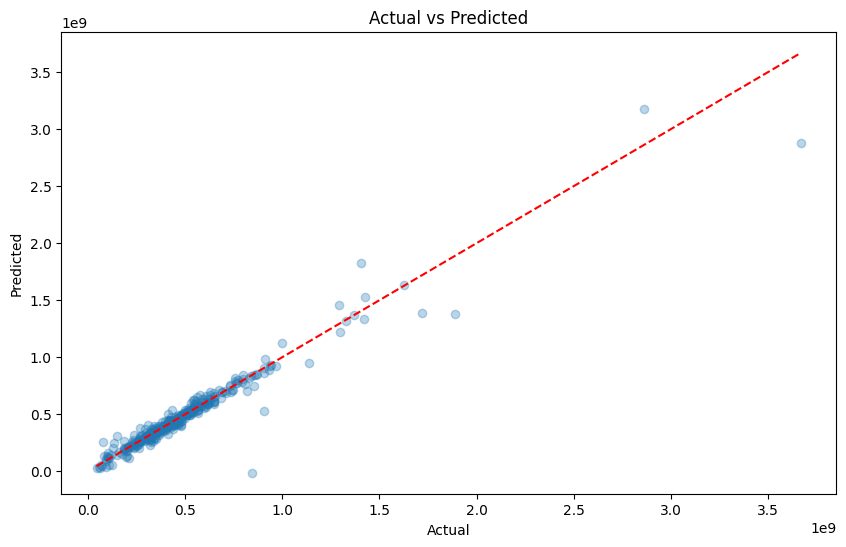

In [15]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [18]:
# Save the LightGBM model
# lgbm_model.save_model(f'{MODEL_PATH}/lgbm_model.joblib')

In [16]:
test_instance = pd.DataFrame({
    'manufacture_date': [2011],
    'brand': ['Ford'],
    'model': ['Fiesta'],
    'origin': ['Thái Lan'],
    'type': ['Hatchback'],
    'seats': [5.0],
    'gearbox': ['AT'],
    'fuel': ['petrol'],
    'color': ['white'],
    'mileage_v2': [10000],
    'condition': ['used']
})
test_instance = cast_to_category(test_instance,CAT_COLS)

In [17]:
# convert to instance that lgbm can use
# test_instance_data = lgb.Dataset(data=test_instance, reference=train_data,categorical_feature='auto')

# Make prediction
test_prediction = lgbm_model.predict(test_instance)
print(f"Predicted price: {test_prediction[0]:,.0f} VND")

Predicted price: 233,452,620 VND
